In [1]:
# Cell 1: Check GPU and Install Dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

print("="*60)
print("SETUP: Checking Environment")
print("="*60)

# Check GPU
print(f"\n✓ PyTorch version: {torch.__version__}")
print(f"✓ GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ WARNING: No GPU found! Training will be slow.")

print("\n" + "="*60)

SETUP: Checking Environment

✓ PyTorch version: 2.9.0+cu126
✓ GPU Available: True
✓ GPU Name: Tesla T4
✓ GPU Memory: 15.83 GB




🚀 Generating Improved Dataset...

GENERATING IMPROVED SYNTHETIC SMD-LIKE DATASET
  Features: 38
  Train samples: 30000
  Test samples: 5000
  Target anomaly ratio: 10.0%

  [1/3] Generating training data (normal only)...
  [2/3] Generating test data...
  [3/3] Injecting anomalies (segment-based)...

✓ Dataset generated successfully!
  Train shape: (30000, 38)
  Test shape: (5000, 38)
  Actual anomaly ratio: 12.24%
  Anomaly points: 612/5000


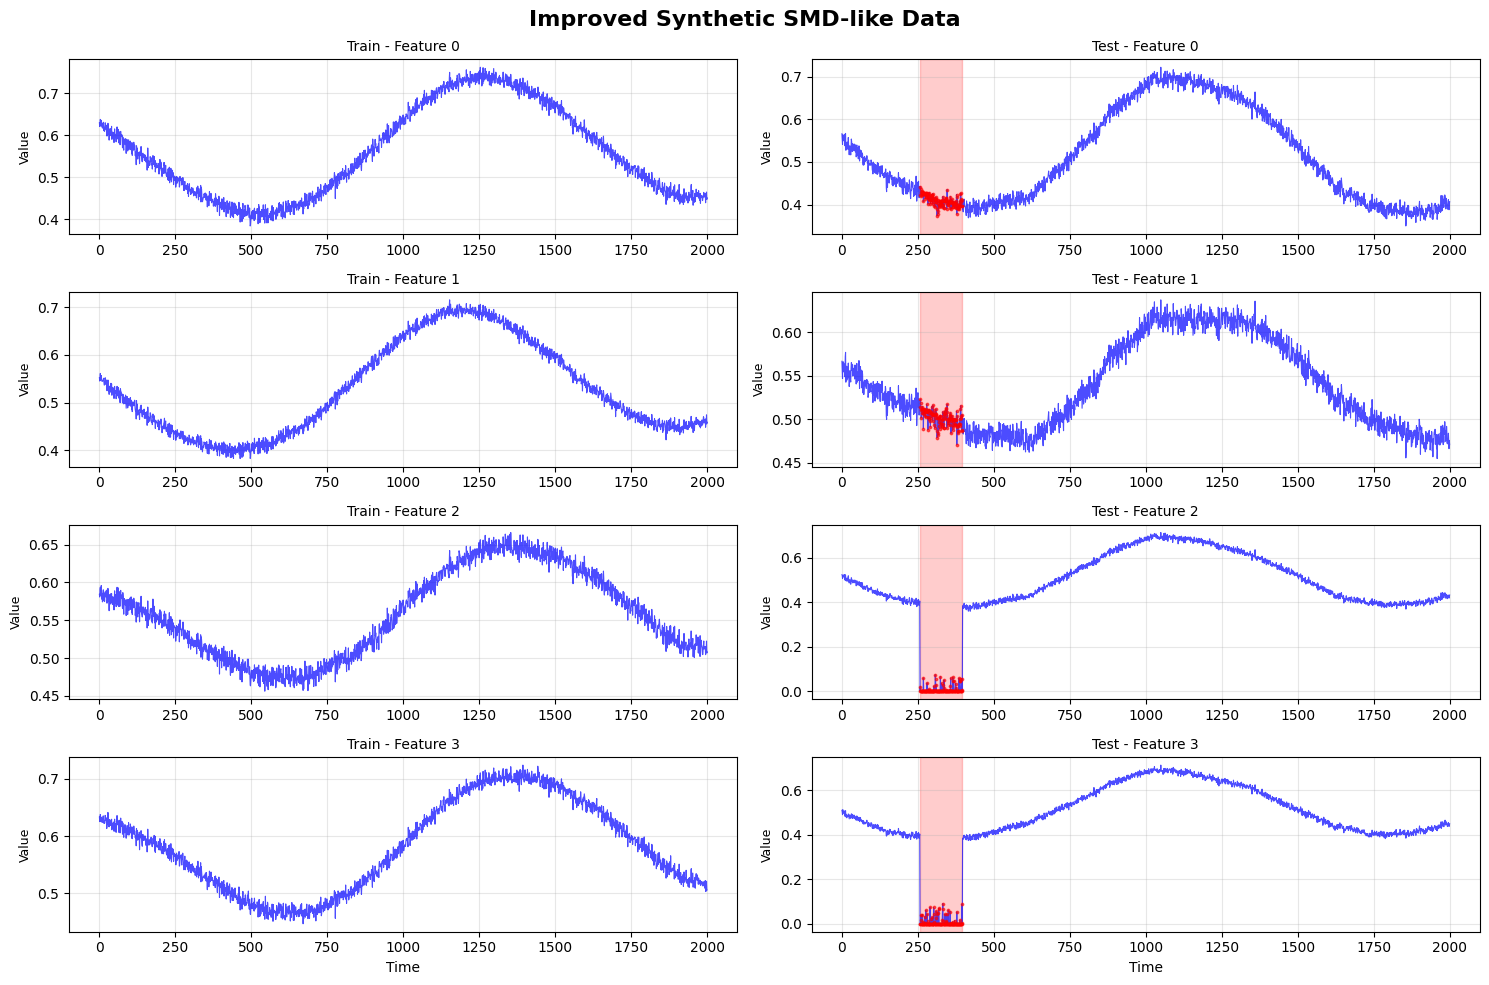

In [16]:
# Cell 2: Improved Synthetic Data Generator
import numpy as np
from scipy import signal

class SyntheticSMDGenerator:
    """Generate synthetic Server Machine Dataset-like data - IMPROVED"""

    def __init__(self, n_features=38, train_length=30000, test_length=5000,
                 anomaly_ratio=0.10, seed=42):  # Increased to 10% anomalies
        self.n_features = n_features
        self.train_length = train_length
        self.test_length = test_length
        self.anomaly_ratio = anomaly_ratio
        self.seed = seed
        np.random.seed(seed)

    def generate_normal_patterns(self, length):
        """Generate normal server behavior patterns"""
        data = np.zeros((length, self.n_features))
        t = np.arange(length)

        for i in range(self.n_features):
            # Base level (centered around 0.5)
            base_level = 0.5

            # Strong daily periodic pattern
            period = 1440  # Daily cycle
            phase = np.random.uniform(0, 2 * np.pi)
            periodic = 0.15 * np.sin(2 * np.pi * t / period + phase)

            # Slower weekly trend
            slow_period = 10080  # Weekly
            trend = 0.08 * np.sin(2 * np.pi * t / slow_period)

            # Small random walk
            random_walk = np.cumsum(np.random.normal(0, 0.0005, length))
            random_walk = random_walk - np.mean(random_walk)
            if np.std(random_walk) > 0:
                random_walk = 0.03 * random_walk / np.std(random_walk)

            # Gaussian noise
            noise = np.random.normal(0, 0.01, length)

            # Combine
            data[:, i] = base_level + periodic + trend + random_walk + noise

        # Add strong correlations between feature groups
        for i in range(0, self.n_features - 4, 5):
            # Create feature groups that are highly correlated
            correlation = 0.7
            for j in range(1, min(4, self.n_features - i)):
                data[:, i+j] = correlation * data[:, i] + (1 - correlation) * data[:, i+j]

        data = np.clip(data, 0, 1)
        return data

    def inject_anomalies(self, data, anomaly_ratio):
        """Inject more obvious and varied anomalies"""
        labels = np.zeros(len(data), dtype=int)
        n_anomalies = int(len(data) * anomaly_ratio)

        # Create anomaly segments (not just points)
        num_segments = max(1, n_anomalies // 100)  # Each segment ~100 points

        for _ in range(num_segments):
            start_pos = np.random.randint(50, len(data) - 200)
            segment_length = np.random.randint(50, 150)
            end_pos = min(start_pos + segment_length, len(data))

            anomaly_type = np.random.choice(['spike_pattern', 'drop_pattern',
                                            'level_shift', 'variance_change'])

            n_affected = np.random.randint(5, 15)  # Affect more features
            affected_features = np.random.choice(self.n_features, n_affected, replace=False)

            if anomaly_type == 'spike_pattern':
                # Repeated spikes
                spike_pattern = np.random.uniform(0.4, 0.7, (end_pos - start_pos, n_affected))
                data[start_pos:end_pos, affected_features] += spike_pattern
                labels[start_pos:end_pos] = 1

            elif anomaly_type == 'drop_pattern':
                # Sustained drop
                drop_pattern = np.random.uniform(0.3, 0.6, (end_pos - start_pos, n_affected))
                data[start_pos:end_pos, affected_features] -= drop_pattern
                labels[start_pos:end_pos] = 1

            elif anomaly_type == 'level_shift':
                # Sudden level change
                shift = np.random.choice([-0.4, 0.4])
                data[start_pos:end_pos, affected_features] += shift
                labels[start_pos:end_pos] = 1

            elif anomaly_type == 'variance_change':
                # Increased variance
                noise_pattern = np.random.normal(0, 0.15, (end_pos - start_pos, n_affected))
                data[start_pos:end_pos, affected_features] += noise_pattern
                labels[start_pos:end_pos] = 1

        data = np.clip(data, 0, 1)
        return data, labels

    def generate_dataset(self):
        """Generate complete synthetic dataset"""
        print("\n" + "="*60)
        print("GENERATING IMPROVED SYNTHETIC SMD-LIKE DATASET")
        print("="*60)
        print(f"  Features: {self.n_features}")
        print(f"  Train samples: {self.train_length}")
        print(f"  Test samples: {self.test_length}")
        print(f"  Target anomaly ratio: {self.anomaly_ratio * 100}%")

        print("\n  [1/3] Generating training data (normal only)...")
        train_data = self.generate_normal_patterns(self.train_length)

        print("  [2/3] Generating test data...")
        test_data = self.generate_normal_patterns(self.test_length)

        print("  [3/3] Injecting anomalies (segment-based)...")
        test_data, test_labels = self.inject_anomalies(test_data, self.anomaly_ratio)

        actual_ratio = test_labels.sum() / len(test_labels)
        print(f"\n✓ Dataset generated successfully!")
        print(f"  Train shape: {train_data.shape}")
        print(f"  Test shape: {test_data.shape}")
        print(f"  Actual anomaly ratio: {actual_ratio * 100:.2f}%")
        print(f"  Anomaly points: {test_labels.sum()}/{len(test_labels)}")
        print("="*60)

        return train_data, test_data, test_labels

    def visualize_samples(self, train_data, test_data, test_labels):
        """Visualize sample data"""
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(4, 2, figsize=(15, 10))
        fig.suptitle('Improved Synthetic SMD-like Data', fontsize=16, fontweight='bold')

        for i in range(4):
            # Training data
            axes[i, 0].plot(train_data[:2000, i], linewidth=0.8, color='blue', alpha=0.7)
            axes[i, 0].set_title(f'Train - Feature {i}', fontsize=10)
            axes[i, 0].set_ylabel('Value', fontsize=9)
            axes[i, 0].grid(True, alpha=0.3)

            # Test data with anomalies
            axes[i, 1].plot(test_data[:2000, i], linewidth=0.8, color='blue', alpha=0.7)
            anomaly_indices = np.where(test_labels[:2000] == 1)[0]
            if len(anomaly_indices) > 0:
                axes[i, 1].scatter(anomaly_indices, test_data[anomaly_indices, i],
                                  color='red', s=3, alpha=0.6, zorder=5)
            axes[i, 1].set_title(f'Test - Feature {i}', fontsize=10)
            axes[i, 1].set_ylabel('Value', fontsize=9)
            axes[i, 1].grid(True, alpha=0.3)

            # Highlight anomaly regions
            if len(anomaly_indices) > 0:
                axes[i, 1].axvspan(anomaly_indices[0], anomaly_indices[-1],
                                  alpha=0.2, color='red')

        axes[3, 0].set_xlabel('Time')
        axes[3, 1].set_xlabel('Time')

        plt.tight_layout()
        plt.show()

# Generate IMPROVED data
print("\n🚀 Generating Improved Dataset...")
generator = SyntheticSMDGenerator(
    n_features=38,
    train_length=30000,  # More training data
    test_length=5000,    # More test data
    anomaly_ratio=0.10,  # 10% anomalies (more balanced)
    seed=42
)

train_data, test_data, test_labels = generator.generate_dataset()
generator.visualize_samples(train_data, test_data, test_labels)

In [17]:
# Cell 3: Fixed Data Preprocessing
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesPreprocessor:
    """Preprocess multivariate time series data - FIXED"""

    def __init__(self, window_size=100, stride=50):  # stride=50 (less overlap)
        self.window_size = window_size
        self.stride = stride
        self.scaler = StandardScaler()

    def normalize(self, train_data, test_data):
        """Normalize using training statistics"""
        self.scaler.fit(train_data)
        train_normalized = self.scaler.transform(train_data)
        test_normalized = self.scaler.transform(test_data)
        return train_normalized, test_normalized

    def create_windows(self, data, labels=None):
        """Create sliding windows from time series"""
        windows = []
        window_labels = []

        for i in range(0, len(data) - self.window_size + 1, self.stride):
            window = data[i:i + self.window_size]
            windows.append(window)

            if labels is not None:
                # Window is anomalous if >50% of points are anomalous
                window_label_sum = labels[i:i + self.window_size].sum()
                label = 1 if window_label_sum > (self.window_size * 0.3) else 0  # 30% threshold
                window_labels.append(label)

        windows = np.array(windows, dtype=np.float32)

        if labels is not None:
            window_labels = np.array(window_labels, dtype=np.float32)
            return windows, window_labels

        return windows, None

    def process(self, train_data, test_data, test_labels):
        """Complete preprocessing pipeline"""
        print("\n" + "="*60)
        print("PREPROCESSING DATA (IMPROVED)")
        print("="*60)

        print("  [1/2] Normalizing...")
        train_norm, test_norm = self.normalize(train_data, test_data)

        print("  [2/2] Creating windows (stride=50 for less overlap)...")
        train_windows, _ = self.create_windows(train_norm)
        test_windows, test_window_labels = self.create_windows(test_norm, test_labels)

        # Calculate actual distribution
        if test_window_labels is not None:
            anomaly_count = np.sum(test_window_labels)
            normal_count = len(test_window_labels) - anomaly_count
            print(f"\n  Window label distribution:")
            print(f"    Normal windows: {normal_count} ({normal_count/len(test_window_labels)*100:.1f}%)")
            print(f"    Anomaly windows: {anomaly_count} ({anomaly_count/len(test_window_labels)*100:.1f}%)")

        print(f"\n✓ Preprocessing complete!")
        print(f"  Train windows: {train_windows.shape}")
        print(f"  Test windows: {test_windows.shape}")
        print("="*60)

        return train_windows, test_windows, test_window_labels


class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series windows"""

    def __init__(self, windows, labels=None):
        self.windows = torch.FloatTensor(windows)
        self.labels = torch.FloatTensor(labels) if labels is not None else None

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.windows[idx], self.labels[idx]
        return self.windows[idx]

# Preprocess with better settings
preprocessor = TimeSeriesPreprocessor(window_size=100, stride=50)
train_windows, test_windows, test_window_labels = preprocessor.process(
    train_data, test_data, test_labels
)

# Create datasets
train_dataset = TimeSeriesDataset(train_windows)
test_dataset = TimeSeriesDataset(test_windows, test_window_labels)

# Create dataloaders
batch_size = 64  # Smaller batch size for better gradients
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\n✓ DataLoaders created")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")


PREPROCESSING DATA (IMPROVED)
  [1/2] Normalizing...
  [2/2] Creating windows (stride=50 for less overlap)...

  Window label distribution:
    Normal windows: 84.0 (84.8%)
    Anomaly windows: 15.0 (15.2%)

✓ Preprocessing complete!
  Train windows: (599, 100, 38)
  Test windows: (99, 100, 38)

✓ DataLoaders created
  Batch size: 64
  Train batches: 10
  Test batches: 2


In [18]:
# Cell 4: Data Augmentation
import torch

class GeometricAugmentation:
    """Data augmentation for multivariate time series"""

    def __init__(self, mask_ratio=0.15, jitter_sigma=0.03):
        self.mask_ratio = mask_ratio
        self.jitter_sigma = jitter_sigma

    def random_masking(self, x):
        """Randomly mask portions of time series"""
        mask = torch.rand_like(x) > self.mask_ratio
        return x * mask

    def jittering(self, x):
        """Add random Gaussian noise"""
        noise = torch.randn_like(x) * self.jitter_sigma
        return x + noise

    def augment(self, x):
        """Apply random augmentation"""
        if np.random.rand() > 0.5:
            x = self.random_masking(x)
        if np.random.rand() > 0.5:
            x = self.jittering(x)
        return x

augmenter = GeometricAugmentation()
print("✓ Data augmentation module ready")

✓ Data augmentation module ready


In [19]:
# Cell 5: Transformer Model
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""

    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerEncoder(nn.Module):
    """Transformer encoder for time series"""

    def __init__(self, n_features=38, d_model=128, n_heads=8, n_layers=4, dropout=0.1):
        super().__init__()

        self.n_features = n_features
        self.d_model = d_model

        # Input projection
        self.input_projection = nn.Linear(n_features, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output projection for reconstruction
        self.output_projection = nn.Linear(d_model, n_features)

    def forward(self, x):
        # x shape: (batch, seq_len, n_features)

        # Project to d_model
        x = self.input_projection(x)  # (batch, seq_len, d_model)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Transformer encoding
        encoded = self.transformer_encoder(x)  # (batch, seq_len, d_model)

        # Reconstruct
        reconstructed = self.output_projection(encoded)  # (batch, seq_len, n_features)

        return encoded, reconstructed

print("✓ Transformer model defined")

✓ Transformer model defined


In [20]:
# Cell 6: GAN Components
import torch.nn as nn

class Generator(nn.Module):
    """GAN Generator to create normal patterns"""

    def __init__(self, latent_dim=64, d_model=128, seq_len=100, n_features=38):
        super().__init__()

        self.seq_len = seq_len
        self.d_model = d_model

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, seq_len * d_model),
            nn.Tanh()
        )

        self.output_proj = nn.Linear(d_model, n_features)

    def forward(self, z):
        # z shape: (batch, latent_dim)
        x = self.model(z)  # (batch, seq_len * d_model)
        x = x.view(-1, self.seq_len, self.d_model)  # (batch, seq_len, d_model)
        x = self.output_proj(x)  # (batch, seq_len, n_features)
        return x


class Discriminator(nn.Module):
    """GAN Discriminator to distinguish real vs generated"""

    def __init__(self, seq_len=100, n_features=38):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(seq_len * n_features, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch, seq_len, n_features)
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)

print("✓ GAN components defined")

✓ GAN components defined


In [21]:
# Cell 7: Contrastive Loss
import torch
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    """NT-Xent (Normalized Temperature-scaled Cross Entropy) Loss"""

    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features1, features2):
        """
        features1, features2: (batch, seq_len, d_model)
        """
        # Global average pooling
        z1 = features1.mean(dim=1)  # (batch, d_model)
        z2 = features2.mean(dim=1)  # (batch, d_model)

        # Normalize
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Concatenate
        batch_size = z1.size(0)
        z = torch.cat([z1, z2], dim=0)  # (2*batch, d_model)

        # Compute similarity matrix
        sim_matrix = torch.mm(z, z.t()) / self.temperature  # (2*batch, 2*batch)

        # Create labels (positive pairs are diagonal)
        labels = torch.arange(batch_size).to(z.device)
        labels = torch.cat([labels + batch_size, labels])

        # Mask out self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -9e15)

        # Compute loss
        loss = F.cross_entropy(sim_matrix, labels)

        return loss

print("✓ Contrastive loss defined")

✓ Contrastive loss defined


In [22]:
# Cell 8: Complete Anomaly Detection Model
import torch
import torch.nn as nn

class AnomalyDetector(nn.Module):
    """Complete anomaly detection framework"""

    def __init__(self, n_features=38, seq_len=100, d_model=128, n_heads=8,
                 n_layers=4, latent_dim=64, dropout=0.1):
        super().__init__()

        self.seq_len = seq_len
        self.n_features = n_features

        # Transformer encoder
        self.transformer = TransformerEncoder(
            n_features=n_features,
            d_model=d_model,
            n_heads=n_heads,
            n_layers=n_layers,
            dropout=dropout
        )

        # GAN components
        self.generator = Generator(latent_dim, d_model, seq_len, n_features)
        self.discriminator = Discriminator(seq_len, n_features)

        # Contrastive loss
        self.contrastive_loss = ContrastiveLoss(temperature=0.07)

    def forward(self, x, augmented_x=None):
        """
        Forward pass
        x: (batch, seq_len, n_features)
        augmented_x: (batch, seq_len, n_features) - augmented version
        """
        # Transformer encoding and reconstruction
        encoded, reconstructed = self.transformer(x)

        # If augmented version provided, compute contrastive loss
        if augmented_x is not None:
            encoded_aug, _ = self.transformer(augmented_x)
            contrastive_loss = self.contrastive_loss(encoded, encoded_aug)
        else:
            contrastive_loss = torch.tensor(0.0).to(x.device)

        return {
            'encoded': encoded,
            'reconstructed': reconstructed,
            'contrastive_loss': contrastive_loss
        }

    def compute_anomaly_score(self, x):
        """Compute anomaly score for inference"""
        with torch.no_grad():
            _, reconstructed = self.transformer(x)

            # Reconstruction error
            recon_error = torch.mean((x - reconstructed) ** 2, dim=(1, 2))

            # Discriminator score (lower for anomalies)
            disc_score = self.discriminator(x).squeeze()

            # Combined score
            anomaly_score = recon_error + (1 - disc_score)

        return anomaly_score

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AnomalyDetector(
    n_features=38,
    seq_len=100,
    d_model=128,
    n_heads=8,
    n_layers=4,
    latent_dim=64,
    dropout=0.1
).to(device)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(f"✓ Model initialized on {device}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("="*60)

MODEL ARCHITECTURE
✓ Model initialized on cuda
  Total parameters: 9,634,509
  Trainable parameters: 9,634,509


In [23]:
# Cell 9: Training Function (CORRECTED)
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

def train_epoch(model, train_loader, optimizer_main, optimizer_G, optimizer_D,
                augmenter, device, alpha=1.0, beta=0.5, gamma=0.3):
    """Train for one epoch"""
    model.train()

    total_loss = 0
    total_recon_loss = 0
    total_contrast_loss = 0
    total_gan_loss = 0

    progress_bar = tqdm(train_loader, desc="Training")

    for batch in progress_bar:
        x = batch.to(device)
        batch_size = x.size(0)

        # Data augmentation
        x_aug = augmenter.augment(x)

        # ============ Train Discriminator ============
        optimizer_D.zero_grad()

        # Real data
        real_labels = torch.ones(batch_size, 1).to(device)
        real_pred = model.discriminator(x)
        d_loss_real = F.binary_cross_entropy(real_pred, real_labels)

        # Fake data from generator
        z = torch.randn(batch_size, 64).to(device)
        fake_data = model.generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_pred = model.discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(fake_pred, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # ============ Train Generator ============
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, 64).to(device)
        fake_data = model.generator(z)
        fake_pred = model.discriminator(fake_data)
        g_loss = F.binary_cross_entropy(fake_pred, real_labels)

        g_loss.backward()
        optimizer_G.step()

        # ============ Train Main Model (Transformer) ============
        optimizer_main.zero_grad()

        # Forward pass
        outputs = model(x, x_aug)

        # Reconstruction loss
        recon_loss = F.mse_loss(outputs['reconstructed'], x)

        # Contrastive loss
        contrast_loss = outputs['contrastive_loss']

        # Combined loss for main model (NO GAN loss here!)
        loss = alpha * recon_loss + beta * contrast_loss

        loss.backward()
        optimizer_main.step()

        # Track losses (detach for logging)
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_contrast_loss += contrast_loss.item()
        total_gan_loss += (g_loss.item() + d_loss.item())

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'recon': f'{recon_loss.item():.4f}',
            'contrast': f'{contrast_loss.item():.4f}',
            'D_loss': f'{d_loss.item():.4f}',
            'G_loss': f'{g_loss.item():.4f}'
        })

    n_batches = len(train_loader)
    return {
        'total_loss': total_loss / n_batches,
        'recon_loss': total_recon_loss / n_batches,
        'contrast_loss': total_contrast_loss / n_batches,
        'gan_loss': total_gan_loss / n_batches
    }

print("✓ Training function defined (CORRECTED)")

✓ Training function defined (CORRECTED)


In [24]:
# Cell 10: Evaluation Function
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

def evaluate(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            x, labels = batch
            x = x.to(device)

            # Compute anomaly scores
            scores = model.compute_anomaly_score(x)

            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # Find optimal threshold
    thresholds = np.percentile(all_scores, np.arange(80, 100, 1))
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        predictions = (all_scores > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, predictions, average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Final predictions with best threshold
    predictions = (all_scores > best_threshold).astype(int)

    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, predictions, average='binary'
    )

    try:
        auc = roc_auc_score(all_labels, all_scores)
    except:
        auc = 0.0

    cm = confusion_matrix(all_labels, predictions)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'threshold': best_threshold,
        'confusion_matrix': cm,
        'scores': all_scores,
        'labels': all_labels,
        'predictions': predictions
    }

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [26]:
# Cell 11: Training Loop (OPTIMIZED - FIXED)
print("\n" + "="*60)
print("STARTING OPTIMIZED TRAINING")
print("="*60)

# Reinitialize model for fresh start
model = AnomalyDetector(
    n_features=38,
    seq_len=100,
    d_model=128,
    n_heads=8,
    n_layers=4,
    latent_dim=64,
    dropout=0.1
).to(device)

# Training configuration
NUM_EPOCHS = 40
LEARNING_RATE = 5e-4  # Slightly higher learning rate

# Optimizers
optimizer_main = optim.AdamW(  # AdamW for better regularization
    list(model.transformer.parameters()),
    lr=LEARNING_RATE,
    weight_decay=1e-5
)
optimizer_G = optim.Adam(model.generator.parameters(), lr=LEARNING_RATE * 0.05)
optimizer_D = optim.Adam(model.discriminator.parameters(), lr=LEARNING_RATE * 0.05)

# Learning rate scheduler (REMOVED verbose parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_main, mode='max', factor=0.5, patience=5
)

# Training history
history = {
    'train_loss': [],
    'recon_loss': [],
    'contrast_loss': [],
    'gan_loss': [],
    'val_f1': [],
    'val_recall': [],
    'val_precision': []
}

best_f1 = 0

# OPTIMIZED LOSS WEIGHTS
ALPHA = 1.0   # Reconstruction (main signal)
BETA = 0.2    # Contrastive (reduced)
GAMMA = 0.05  # GAN (minimal influence)

print(f"\nHyperparameters:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Loss Weights - Alpha: {ALPHA}, Beta: {BETA}, Gamma: {GAMMA}")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    # Train
    train_metrics = train_epoch(
        model, train_loader, optimizer_main, optimizer_G, optimizer_D,
        augmenter, device, alpha=ALPHA, beta=BETA, gamma=GAMMA
    )

    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nEvaluating...")
        eval_metrics = evaluate(model, test_loader, device)

        print(f"\n📊 Evaluation Results:")
        print(f"  Precision: {eval_metrics['precision']:.4f}")
        print(f"  Recall: {eval_metrics['recall']:.4f}")
        print(f"  F1-Score: {eval_metrics['f1']:.4f}")
        print(f"  ROC-AUC: {eval_metrics['auc']:.4f}")

        history['val_f1'].append(eval_metrics['f1'])
        history['val_recall'].append(eval_metrics['recall'])
        history['val_precision'].append(eval_metrics['precision'])

        # Learning rate scheduling
        old_lr = optimizer_main.param_groups[0]['lr']
        scheduler.step(eval_metrics['f1'])
        new_lr = optimizer_main.param_groups[0]['lr']

        if new_lr < old_lr:
            print(f"  📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")

        # Save best model
        if eval_metrics['f1'] > best_f1:
            best_f1 = eval_metrics['f1']
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  ✓ Best model saved! (F1: {best_f1:.4f})")

    # Track history
    history['train_loss'].append(train_metrics['total_loss'])
    history['recon_loss'].append(train_metrics['recon_loss'])
    history['contrast_loss'].append(train_metrics['contrast_loss'])
    history['gan_loss'].append(train_metrics['gan_loss'])

    print(f"\n📈 Training Metrics:")
    print(f"  Total Loss: {train_metrics['total_loss']:.4f}")
    print(f"  Recon Loss: {train_metrics['recon_loss']:.4f}")
    print(f"  Contrast Loss: {train_metrics['contrast_loss']:.4f}")
    print(f"  GAN Loss: {train_metrics['gan_loss']:.4f}")
    print(f"  Learning Rate: {optimizer_main.param_groups[0]['lr']:.6f}")

print("\n" + "="*60)
print("✓ TRAINING COMPLETE!")
print(f"🎯 Best F1-Score achieved: {best_f1:.4f}")
print("="*60)


STARTING OPTIMIZED TRAINING

Hyperparameters:
  Epochs: 40
  Learning Rate: 0.0005
  Loss Weights - Alpha: 1.0, Beta: 0.2, Gamma: 0.05

Epoch 1/40


Training: 100%|██████████| 10/10 [00:00<00:00, 11.46it/s, loss=0.3393, recon=0.1862, contrast=0.7655, D_loss=0.6598, G_loss=0.6438]



📈 Training Metrics:
  Total Loss: 0.8366
  Recon Loss: 0.5139
  Contrast Loss: 1.6133
  GAN Loss: 1.3297
  Learning Rate: 0.000500

Epoch 2/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s, loss=0.1587, recon=0.0928, contrast=0.3294, D_loss=0.6457, G_loss=0.6276]



📈 Training Metrics:
  Total Loss: 0.3566
  Recon Loss: 0.1237
  Contrast Loss: 1.1641
  GAN Loss: 1.2786
  Learning Rate: 0.000500

Epoch 3/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s, loss=0.1225, recon=0.0747, contrast=0.2389, D_loss=0.5902, G_loss=0.6170]



📈 Training Metrics:
  Total Loss: 0.2586
  Recon Loss: 0.0845
  Contrast Loss: 0.8708
  GAN Loss: 1.2343
  Learning Rate: 0.000500

Epoch 4/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s, loss=0.1194, recon=0.0514, contrast=0.3402, D_loss=0.5444, G_loss=0.6184]



📈 Training Metrics:
  Total Loss: 0.2238
  Recon Loss: 0.0603
  Contrast Loss: 0.8177
  GAN Loss: 1.1898
  Learning Rate: 0.000500

Epoch 5/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s, loss=0.0980, recon=0.0495, contrast=0.2424, D_loss=0.5265, G_loss=0.6206]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.01it/s]



📊 Evaluation Results:
  Precision: 1.0000
  Recall: 0.9333
  F1-Score: 0.9655
  ROC-AUC: 0.9984
  ✓ Best model saved! (F1: 0.9655)

📈 Training Metrics:
  Total Loss: 0.2223
  Recon Loss: 0.0489
  Contrast Loss: 0.8671
  GAN Loss: 1.1566
  Learning Rate: 0.000500

Epoch 6/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s, loss=0.1495, recon=0.0417, contrast=0.5394, D_loss=0.4675, G_loss=0.6418]



📈 Training Metrics:
  Total Loss: 0.2135
  Recon Loss: 0.0444
  Contrast Loss: 0.8456
  GAN Loss: 1.1303
  Learning Rate: 0.000500

Epoch 7/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s, loss=0.1219, recon=0.0401, contrast=0.4090, D_loss=0.4454, G_loss=0.6703]



📈 Training Metrics:
  Total Loss: 0.1930
  Recon Loss: 0.0411
  Contrast Loss: 0.7596
  GAN Loss: 1.1140
  Learning Rate: 0.000500

Epoch 8/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.00it/s, loss=0.0954, recon=0.0371, contrast=0.2913, D_loss=0.4198, G_loss=0.6906]



📈 Training Metrics:
  Total Loss: 0.1909
  Recon Loss: 0.0399
  Contrast Loss: 0.7549
  GAN Loss: 1.1037
  Learning Rate: 0.000500

Epoch 9/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s, loss=0.0784, recon=0.0395, contrast=0.1945, D_loss=0.3909, G_loss=0.6989]



📈 Training Metrics:
  Total Loss: 0.1740
  Recon Loss: 0.0372
  Contrast Loss: 0.6839
  GAN Loss: 1.0992
  Learning Rate: 0.000500

Epoch 10/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.06it/s, loss=0.0974, recon=0.0399, contrast=0.2870, D_loss=0.3905, G_loss=0.7054]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 20.11it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9984
  ✓ Best model saved! (F1: 0.9677)

📈 Training Metrics:
  Total Loss: 0.1700
  Recon Loss: 0.0379
  Contrast Loss: 0.6602
  GAN Loss: 1.0956
  Learning Rate: 0.000500

Epoch 11/40


Training: 100%|██████████| 10/10 [00:00<00:00, 12.02it/s, loss=0.0634, recon=0.0398, contrast=0.1180, D_loss=0.3733, G_loss=0.7148]



📈 Training Metrics:
  Total Loss: 0.1595
  Recon Loss: 0.0410
  Contrast Loss: 0.5925
  GAN Loss: 1.0959
  Learning Rate: 0.000500

Epoch 12/40


Training: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s, loss=0.1293, recon=0.0349, contrast=0.4720, D_loss=0.3822, G_loss=0.7275]



📈 Training Metrics:
  Total Loss: 0.1575
  Recon Loss: 0.0371
  Contrast Loss: 0.6018
  GAN Loss: 1.1091
  Learning Rate: 0.000500

Epoch 13/40


Training: 100%|██████████| 10/10 [00:00<00:00, 12.10it/s, loss=0.0848, recon=0.0340, contrast=0.2541, D_loss=0.3906, G_loss=0.7420]



📈 Training Metrics:
  Total Loss: 0.1432
  Recon Loss: 0.0345
  Contrast Loss: 0.5436
  GAN Loss: 1.1199
  Learning Rate: 0.000500

Epoch 14/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s, loss=0.0837, recon=0.0380, contrast=0.2283, D_loss=0.3892, G_loss=0.7620]



📈 Training Metrics:
  Total Loss: 0.1419
  Recon Loss: 0.0332
  Contrast Loss: 0.5434
  GAN Loss: 1.1243
  Learning Rate: 0.000500

Epoch 15/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s, loss=0.0983, recon=0.0326, contrast=0.3285, D_loss=0.4079, G_loss=0.7726]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.02it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9976

📈 Training Metrics:
  Total Loss: 0.1325
  Recon Loss: 0.0346
  Contrast Loss: 0.4893
  GAN Loss: 1.1331
  Learning Rate: 0.000500

Epoch 16/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s, loss=0.0776, recon=0.0309, contrast=0.2335, D_loss=0.3606, G_loss=0.7618]



📈 Training Metrics:
  Total Loss: 0.1189
  Recon Loss: 0.0317
  Contrast Loss: 0.4361
  GAN Loss: 1.1401
  Learning Rate: 0.000500

Epoch 17/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s, loss=0.0630, recon=0.0325, contrast=0.1526, D_loss=0.3845, G_loss=0.7959]



📈 Training Metrics:
  Total Loss: 0.1085
  Recon Loss: 0.0314
  Contrast Loss: 0.3859
  GAN Loss: 1.1533
  Learning Rate: 0.000500

Epoch 18/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s, loss=0.0746, recon=0.0340, contrast=0.2030, D_loss=0.3242, G_loss=0.8166]



📈 Training Metrics:
  Total Loss: 0.1035
  Recon Loss: 0.0317
  Contrast Loss: 0.3591
  GAN Loss: 1.1668
  Learning Rate: 0.000500

Epoch 19/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s, loss=0.0836, recon=0.0331, contrast=0.2523, D_loss=0.3301, G_loss=0.8980]



📈 Training Metrics:
  Total Loss: 0.1059
  Recon Loss: 0.0310
  Contrast Loss: 0.3744
  GAN Loss: 1.2011
  Learning Rate: 0.000500

Epoch 20/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s, loss=0.0410, recon=0.0296, contrast=0.0570, D_loss=0.3008, G_loss=1.0289]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.03it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9976

📈 Training Metrics:
  Total Loss: 0.0953
  Recon Loss: 0.0307
  Contrast Loss: 0.3231
  GAN Loss: 1.2544
  Learning Rate: 0.000500

Epoch 21/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s, loss=0.0400, recon=0.0287, contrast=0.0568, D_loss=0.2567, G_loss=1.1175]



📈 Training Metrics:
  Total Loss: 0.0895
  Recon Loss: 0.0297
  Contrast Loss: 0.2992
  GAN Loss: 1.3262
  Learning Rate: 0.000500

Epoch 22/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s, loss=0.0680, recon=0.0295, contrast=0.1929, D_loss=0.2509, G_loss=1.1975]



📈 Training Metrics:
  Total Loss: 0.0948
  Recon Loss: 0.0289
  Contrast Loss: 0.3299
  GAN Loss: 1.4039
  Learning Rate: 0.000500

Epoch 23/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, loss=0.0651, recon=0.0286, contrast=0.1824, D_loss=0.2358, G_loss=1.2653]



📈 Training Metrics:
  Total Loss: 0.0944
  Recon Loss: 0.0287
  Contrast Loss: 0.3288
  GAN Loss: 1.4802
  Learning Rate: 0.000500

Epoch 24/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.09it/s, loss=0.0403, recon=0.0260, contrast=0.0713, D_loss=0.2276, G_loss=1.2528]



📈 Training Metrics:
  Total Loss: 0.0880
  Recon Loss: 0.0268
  Contrast Loss: 0.3059
  GAN Loss: 1.5068
  Learning Rate: 0.000500

Epoch 25/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s, loss=0.0440, recon=0.0259, contrast=0.0907, D_loss=0.2078, G_loss=1.3726]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 20.15it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9976

📈 Training Metrics:
  Total Loss: 0.0806
  Recon Loss: 0.0265
  Contrast Loss: 0.2708
  GAN Loss: 1.5320
  Learning Rate: 0.000500

Epoch 26/40


Training: 100%|██████████| 10/10 [00:00<00:00, 12.08it/s, loss=0.0747, recon=0.0279, contrast=0.2340, D_loss=0.2021, G_loss=1.4371]



📈 Training Metrics:
  Total Loss: 0.0889
  Recon Loss: 0.0267
  Contrast Loss: 0.3113
  GAN Loss: 1.6292
  Learning Rate: 0.000500

Epoch 27/40


Training: 100%|██████████| 10/10 [00:00<00:00, 12.08it/s, loss=0.0556, recon=0.0258, contrast=0.1492, D_loss=0.2201, G_loss=1.4842]



📈 Training Metrics:
  Total Loss: 0.0943
  Recon Loss: 0.0266
  Contrast Loss: 0.3386
  GAN Loss: 1.6733
  Learning Rate: 0.000500

Epoch 28/40


Training: 100%|██████████| 10/10 [00:00<00:00, 12.43it/s, loss=0.0622, recon=0.0261, contrast=0.1805, D_loss=0.1684, G_loss=1.6566]



📈 Training Metrics:
  Total Loss: 0.0801
  Recon Loss: 0.0254
  Contrast Loss: 0.2736
  GAN Loss: 1.7507
  Learning Rate: 0.000500

Epoch 29/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s, loss=0.0443, recon=0.0224, contrast=0.1095, D_loss=0.1298, G_loss=1.8649]



📈 Training Metrics:
  Total Loss: 0.0834
  Recon Loss: 0.0243
  Contrast Loss: 0.2956
  GAN Loss: 1.9490
  Learning Rate: 0.000500

Epoch 30/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s, loss=0.0298, recon=0.0242, contrast=0.0278, D_loss=0.1270, G_loss=2.1208]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.38it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9976

📈 Training Metrics:
  Total Loss: 0.0763
  Recon Loss: 0.0240
  Contrast Loss: 0.2616
  GAN Loss: 2.0933
  Learning Rate: 0.000500

Epoch 31/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s, loss=0.0414, recon=0.0246, contrast=0.0838, D_loss=0.1218, G_loss=2.1160]



📈 Training Metrics:
  Total Loss: 0.0746
  Recon Loss: 0.0243
  Contrast Loss: 0.2517
  GAN Loss: 2.1489
  Learning Rate: 0.000500

Epoch 32/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.36it/s, loss=0.0591, recon=0.0242, contrast=0.1743, D_loss=0.1001, G_loss=2.1348]



📈 Training Metrics:
  Total Loss: 0.0844
  Recon Loss: 0.0238
  Contrast Loss: 0.3029
  GAN Loss: 2.1990
  Learning Rate: 0.000500

Epoch 33/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s, loss=0.0581, recon=0.0227, contrast=0.1769, D_loss=0.0919, G_loss=2.1931]



📈 Training Metrics:
  Total Loss: 0.0827
  Recon Loss: 0.0239
  Contrast Loss: 0.2943
  GAN Loss: 2.3139
  Learning Rate: 0.000500

Epoch 34/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s, loss=0.0267, recon=0.0226, contrast=0.0210, D_loss=0.0973, G_loss=2.3547]



📈 Training Metrics:
  Total Loss: 0.0778
  Recon Loss: 0.0232
  Contrast Loss: 0.2728
  GAN Loss: 2.3971
  Learning Rate: 0.000500

Epoch 35/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s, loss=0.0308, recon=0.0240, contrast=0.0340, D_loss=0.1151, G_loss=2.3869]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 21.01it/s]



📊 Evaluation Results:
  Precision: 0.8824
  Recall: 1.0000
  F1-Score: 0.9375
  ROC-AUC: 0.9968

📈 Training Metrics:
  Total Loss: 0.0794
  Recon Loss: 0.0239
  Contrast Loss: 0.2771
  GAN Loss: 2.5444
  Learning Rate: 0.000500

Epoch 36/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s, loss=0.0362, recon=0.0218, contrast=0.0721, D_loss=0.0846, G_loss=2.7363]



📈 Training Metrics:
  Total Loss: 0.0750
  Recon Loss: 0.0231
  Contrast Loss: 0.2595
  GAN Loss: 2.6172
  Learning Rate: 0.000500

Epoch 37/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.37it/s, loss=0.0630, recon=0.0241, contrast=0.1948, D_loss=0.0791, G_loss=2.5932]



📈 Training Metrics:
  Total Loss: 0.0868
  Recon Loss: 0.0236
  Contrast Loss: 0.3162
  GAN Loss: 2.6875
  Learning Rate: 0.000500

Epoch 38/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s, loss=0.0370, recon=0.0243, contrast=0.0635, D_loss=0.1036, G_loss=2.6758]



📈 Training Metrics:
  Total Loss: 0.0815
  Recon Loss: 0.0239
  Contrast Loss: 0.2882
  GAN Loss: 2.7485
  Learning Rate: 0.000500

Epoch 39/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, loss=0.0620, recon=0.0230, contrast=0.1955, D_loss=0.0752, G_loss=2.8534]



📈 Training Metrics:
  Total Loss: 0.0817
  Recon Loss: 0.0234
  Contrast Loss: 0.2914
  GAN Loss: 2.8272
  Learning Rate: 0.000500

Epoch 40/40


Training: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s, loss=0.0569, recon=0.0213, contrast=0.1778, D_loss=0.0804, G_loss=3.1383]



Evaluating...


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 19.94it/s]



📊 Evaluation Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9976
  📉 Learning rate reduced: 0.000500 → 0.000250

📈 Training Metrics:
  Total Loss: 0.0771
  Recon Loss: 0.0230
  Contrast Loss: 0.2707
  GAN Loss: 3.0395
  Learning Rate: 0.000250

✓ TRAINING COMPLETE!
🎯 Best F1-Score achieved: 0.9677


FINAL EVALUATION


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 18.77it/s]


🎯 Final Results:
  Precision: 0.9375
  Recall: 1.0000
  F1-Score: 0.9677
  ROC-AUC: 0.9984

📊 Confusion Matrix:
[[83  1]
 [ 0 15]]


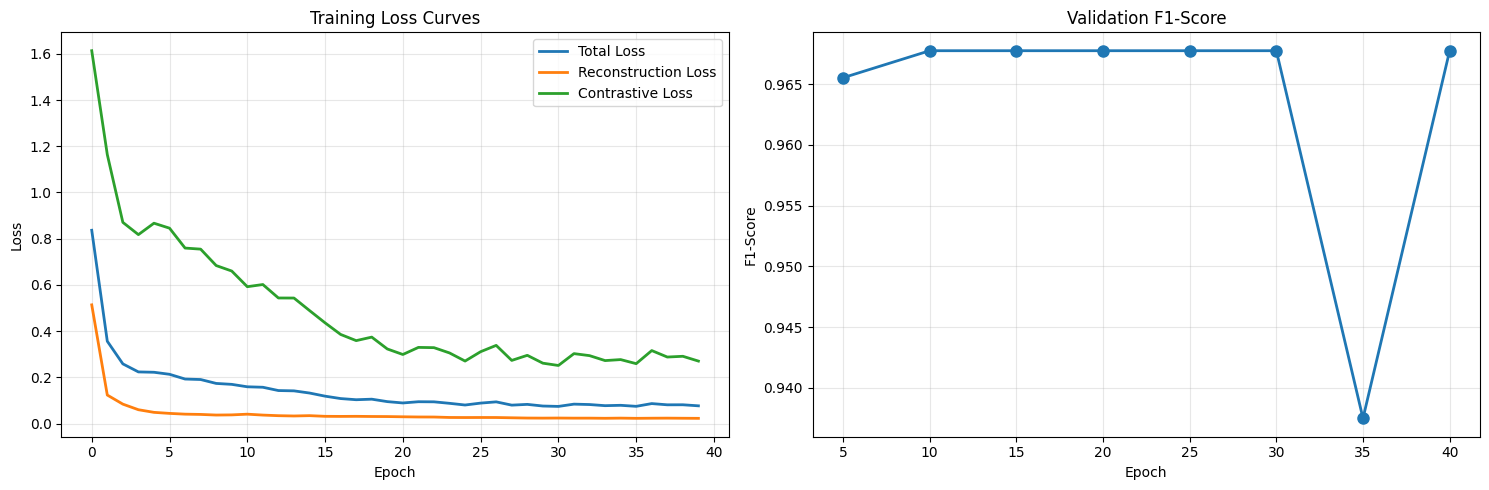

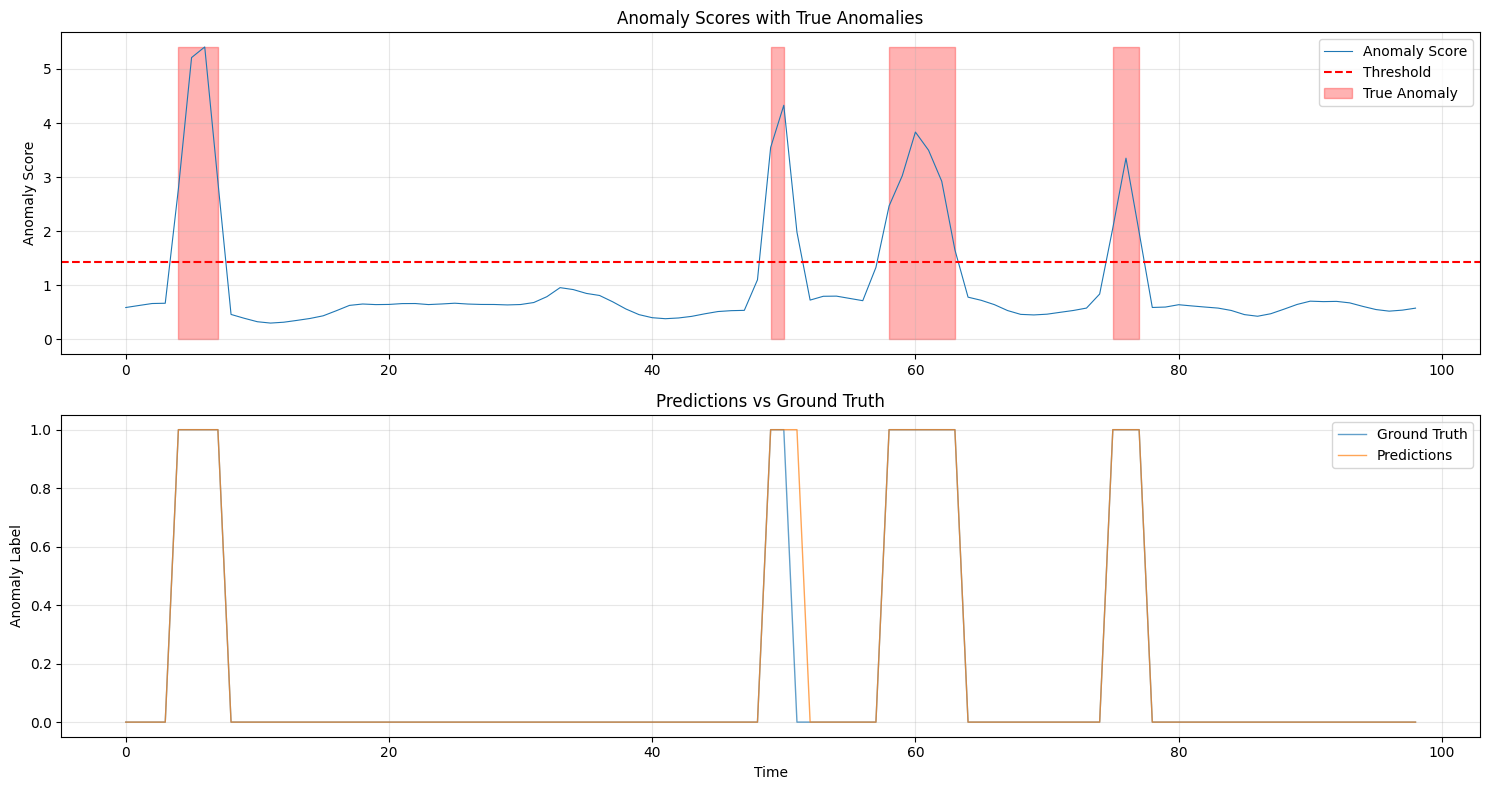


✓ All visualizations complete!


In [27]:
# Cell 12: Final Evaluation and Visualization

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

print("="*60)
print("FINAL EVALUATION")
print("="*60)

final_results = evaluate(model, test_loader, device)

print(f"\n🎯 Final Results:")
print(f"  Precision: {final_results['precision']:.4f}")
print(f"  Recall: {final_results['recall']:.4f}")
print(f"  F1-Score: {final_results['f1']:.4f}")
print(f"  ROC-AUC: {final_results['auc']:.4f}")

print(f"\n📊 Confusion Matrix:")
print(final_results['confusion_matrix'])

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Total Loss', linewidth=2)
axes[0].plot(history['recon_loss'], label='Reconstruction Loss', linewidth=2)
axes[0].plot(history['contrast_loss'], label='Contrastive Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 scores
if len(history['val_f1']) > 0:
    eval_epochs = list(range(5, NUM_EPOCHS + 1, 5))
    axes[1].plot(eval_epochs, history['val_f1'], marker='o', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1-Score')
    axes[1].set_title('Validation F1-Score')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot anomaly detection results
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

sample_length = 1000
scores_sample = final_results['scores'][:sample_length]
labels_sample = final_results['labels'][:sample_length]
preds_sample = final_results['predictions'][:sample_length]

# Anomaly scores
axes[0].plot(scores_sample, linewidth=0.8, label='Anomaly Score')
axes[0].axhline(y=final_results['threshold'], color='r', linestyle='--', label='Threshold')
axes[0].fill_between(range(len(labels_sample)), 0, scores_sample.max(),
                      where=labels_sample==1, alpha=0.3, color='red', label='True Anomaly')
axes[0].set_ylabel('Anomaly Score')
axes[0].set_title('Anomaly Scores with True Anomalies')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Predictions vs Ground Truth
axes[1].plot(labels_sample, linewidth=1, label='Ground Truth', alpha=0.7)
axes[1].plot(preds_sample, linewidth=1, label='Predictions', alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Anomaly Label')
axes[1].set_title('Predictions vs Ground Truth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ All visualizations complete!")